<a href="https://colab.research.google.com/github/JFrankVC/aprendizaje_profundo/blob/main/DL_exam_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Name: *José Francisco Villanueva Cortés*
# Dossier: *742015*

# Actividad S15: Clasificación de acciones

Esta actividad tiene como objetivo general, aplicar los conceptos que has adquirido hasta el momento durante el curso de Aprendizaje Profundo, en particular para realizar la actividad necesitarás de tus conocimientos sobre:

* Pytorch.
* Perceptrón multicapa.
* Redes Neuronales Convolucionales.
* Redes Neuronales Recurrentes.
* Dataset, DataLoader, etc.

## Descripción del problema

Antes de iniciar con la actividad, veamos el tipo de datos que se tienen disponibles para entrenamiento, validación y pruebas. Para esto, te invito
a descarga el archivo [UFC-5.zip](https://drive.google.com/file/d/1tdnOmcZy-7wMp9K9kBLOQhFkLvRX1Zcg/view?usp=sharing) que contiene ejemplos de los datos.

Al descomprimir el archivo encontrarás videos que se encuentran organizados en las siguientes carpetas:

*   Archery
*   Basketball
*   Diving
*   PlayingCello
*   VolleyballSpiking

El nombre de cada carpeta corresponde a la acción que se realiza en los videos almacenados en ella. Por ejemplo, en la carpeta ´VolleyballSpiking´ se encuentra el siguiente video:

A partir de los datos que tenemos a nuestra disposición, nuestra tarea consiste en construir un modelo basado en **Redes Neuronales Convolucionales**, **Redes Neuronales Recurrentes** y el **Perceptrón multi-capa** que teniendo como dato de entrada una secuencia de imágenes (video) nos indique qué acción se esta realizando en el video.

## ¿Trabajar con video?

Un video esta compuesto por una secuencia de imágenes ( frames). A continuación, tienes a tus disposición algunas funciones de utilería que te muestran un ejemplo de cómo cargar un video a memoria (a partir de su path). Al cargar el video en memoria podrás observar cada una de las imágenes que constituyen la secuencia de frames en formato RGB.

In [1]:
# imports
import torch.nn as nn
import torch
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pandas as pd
import zipfile
import torch
from torchvision.datasets import ImageFolder, DatasetFolder
from torchvision import transforms, ops
from torchvision.utils import draw_bounding_boxes
from torchvision.io import read_image, ImageReadMode
from torchvision.models import resnet50, ResNet50_Weights, vgg16, VGG16_Weights, alexnet, AlexNet_Weights
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import cv2 as cv

In [2]:
# Utilities
WHITE = '\033[97m'
YELLOW = '\033[93m'
BLUE = '\033[94m'
GREEN = '\033[92m'
RED = '\033[91m'
RESET = '\033[0m'

checkpoint_load = True
training_mode = 'TEST'

In [3]:
# Connect drive to verify model storage
# Mount the Google Drive
# Allow access - check steps and methods in: https://neptune.ai/blog/google-colab-dealing-with-files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # if Colab root directory is shown, go to /content folder

Mounted at /content/drive


In [4]:
# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

# Change the directory - Google Drive
path = "/content/drive/MyDrive/Colab_DL/Examen_II/Data"
os.chdir(path)

# Check current working directory corresponds to Google Drive
retval = os.getcwd()
print(f"Current working directory {retval}")

Current working directory /content
Current working directory /content/drive/MyDrive/Colab_DL/Examen_II/Data


In [5]:
!ls

UFC-5


In [6]:
# Las imágenes(frames) del video podrían ser rectangulares,
# Tomemos un recuadro del centro del frame
def crop_csquare(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

In [7]:
# Función que permite cargar a memoria un video
#Parámetros de entrada

## path:         ruta y nombre del archivo (video)
## max_frames:   indica cuantas imágenes(frames) queremos que retorne la función,
##               si max_frames=0, la función retorna todas las imágenes del video
## resize:       permite indicar el tamaño deseado de las imágenes que retorna la función

## Parámetro de salida:
## frames        lista de imágenes acorde a los parámetros 'max_frames' y 'resize'.

def load_video(path, max_frames=0, resize=(64, 64)):
    cap = cv.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_csquare(frame)
            frame = cv.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

Para ver algunos ejemplos sobre el manejo de archivos de video en Python, te invito a consultar el material de apoyo que se encuentra en la siguiente sección [Material de apoyo](https://canvas.iteso.mx/courses/38779/modules/items/1562481) del curso de Aprendizaje Profundo en CANVAS.

## Videos a secuencia de imágenes RGB

Verifiquemos el funcionamiento de nuestras funciones, cargando dos videos y verificando las dimensiones del tensor que genera. Pero primero, descomprimamos los datos que descargamos.

In [8]:
# Carguemos un video a manera de ejemplo

path1 = '/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/Archery/v_Archery_g01_c01.avi'
frames=load_video(path1)

In [9]:
# Veamos las características de la secuencia de frames(imágenes) que obtuvimos
# utilizando los valores por defecto en los parámetros max_frames y resize
print(frames.shape)

(131, 64, 64, 3)


In [10]:
# Ahora definamos max_frames = 15 y resize=(32, 32)
# para observar el resultado generado por la función load_video

frames=load_video(path1, max_frames=15, resize=(32, 32))
print(frames.shape)

(15, 32, 32, 3)


Observemos que los parámetros **max_frames** y **resize** tienen relación directa con la longitud de las secuencias de imágenes (que en algún momento sería la entrada a una capa recurrente) y la dimensionalidad de cada elemento(imagen) en la secuencia.

##Desarrollo de la actividad

Dado el contexto previo, tu primer tarea consiste en implementar el siguiente modelo base.     (50 pts)

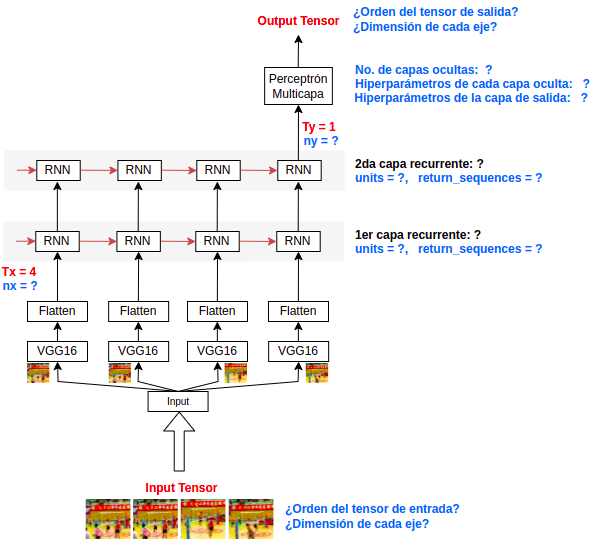

Antes de inciar con la implementación, contesta las preguntas planteadas y define el valor de los hiperparámetros de la red neuronal. Considera que las únicas restricciones de diseño en la arquitectura para este primer modelo son: **Tx = 4** (número de celdas en la primer capa recurrente) y **Ty=1** (en la segunda capa recurrente únicamente nos interesa la activación de la celda que se encuentra más a la derecha).

Antes de continuar, observa que en el diagrama anterior, **nx** denota la dimensionalidad del vector que representa un elemento de la secuencia de entrada y **ny** la dimensionalidad del vector de activación de la celda que se encuentra más a la derecha.

In [11]:
# Escribe aquí la respuesta a cada pregunta planteada
# y justifica el valor que asignes a cada hiperparámetro
# de tu red neuronal.

#  1. ¿Orden del tensor de entrada?
#  Si se consideran batches, el orden es 5, sin batches, sería 4.

#  2. ¿Dimensión de cada eje del tensor de entrada?
#  ANS: Para un orden de 5, sería (batch, n_seq=4, ch=3, w, h). Para un orden de 4, sería (n_seq=4, ch=3, w, h).

#  3. nx = ?


#  4. Parámetros de la 1er capa recurrente: ?

#  5. Parámetros de la 2da capa recurrente: ?

#  6. ny = ?


#  -----   Perceptrón multicapa   -----
#  7. No. capas ocultas: ?

#  8. Hiperparámetros de cada capa oculta

#  9. Hiperparámetros de la capa de salida

#  10. ¿Orden del tensor de salida?

#  11. ¿Dimensión de cada eje del tensor de salida?

**Preparación de datos (entrenamiento, validación y pruebas)**

In [12]:
# Implemente las funciones que requiera para cargar, transformar y generar
# los batchs de ejemplos de entrenamiento, validación y pruebas.


In [13]:
# Change the directory - Google Drive
path = "/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5"
os.chdir(path)

In [14]:
vid_path = "/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/"

In [15]:
# Read folders: get paths and classes of videos
file_list = glob.glob(vid_path + "*")
print(file_list)
data = []
for class_path in file_list:
    class_name = class_path.split("/")[-1]
    for vid_path in glob.glob(class_path + "/*.avi"):
        data.append([vid_path, class_name])
print(data)

['/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/PlayingCello', '/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/Archery', '/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/Diving', '/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/Basketball', '/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/VolleyballSpiking', '/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/model_activity_classification']
[['/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/PlayingCello/v_PlayingCello_g01_c01.avi', 'PlayingCello'], ['/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/PlayingCello/v_PlayingCello_g01_c02.avi', 'PlayingCello'], ['/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/PlayingCello/v_PlayingCello_g01_c03.avi', 'PlayingCello'], ['/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/PlayingCello/v_PlayingCello_g01_c04.avi', 'PlayingCello'], ['/content/drive/MyDrive/Colab_DL/Examen_II/Data/UFC-5/PlayingCello/v_PlayingCello_g01_c05.avi', 'PlayingCello'], ['/co

In [16]:
# Get X and Y from data
data = pd.DataFrame(data, columns=['path', 'class'])    # Conversion to pandas for handling
X_data = data['path'].to_numpy()
Y_data = data['class'].to_numpy()

In [17]:
# Split data for training and testing
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.3, random_state=42)

In [18]:
# Split training datat into training and validation
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

In [19]:
X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape

((19,), (19,), (5,), (5,), (11,), (11,))

In [20]:
# Map classes to idx
classes = []
for class_ in data['class'].unique():
    classes.append(class_)
class_to_idx = {c: i for i, c in enumerate(classes)}
print(class_to_idx)
print(classes)

{'PlayingCello': 0, 'Archery': 1, 'Diving': 2, 'Basketball': 3, 'VolleyballSpiking': 4}
['PlayingCello', 'Archery', 'Diving', 'Basketball', 'VolleyballSpiking']


In [21]:
# Convert to dataframes
data_train = pd.DataFrame({'path': X_train, 'class': Y_train})
data_val = pd.DataFrame({'path': X_val, 'class': Y_val})
data_test = pd.DataFrame({'path': X_test, 'class': Y_test})

In [22]:
data_train.shape, data_val.shape, data_test.shape

((19, 2), (5, 2), (11, 2))

In [23]:
class CustomDataset(torch.utils.data.Dataset):
    # Characterizes a dataset for PyTorch
    def __init__(self, data, mapping):
        #
        self.data = data
        self.mapping = mapping

    def __len__(self):
        # Denotes the total number of samples
        len = self.data.shape[0]
        return len

    def __getitem__(self, index):
        # Select sample
        path_frames = self.data.iloc[index, 0]
        frames = load_video(path_frames, max_frames=4, resize=(64,64))
        label = self.data.iloc[index, 1]
        label = self.mapping[label]
        frames = frames/255.0
        frames = torch.from_numpy(frames)
        frames = frames.permute(0, 3, 1, 2)

        label = nn.functional.one_hot(torch.tensor(label), num_classes=5)

        return frames, label

In [24]:
# Create datatsets from CustomDataset class for use with data loader
dataset_train = CustomDataset(data=data_train, mapping=class_to_idx)
dataset_val = CustomDataset(data=data_val, mapping=class_to_idx)
dataset_test = CustomDataset(data=data_test, mapping=class_to_idx)

In [25]:
dataset_train.__len__(), dataset_val.__len__(), dataset_test.__len__()

(19, 5, 11)

In [26]:
frames, label = dataset_train.__getitem__(4)

In [27]:
frames.shape

torch.Size([4, 3, 64, 64])

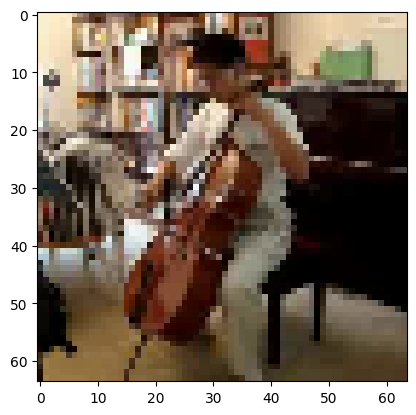

In [28]:
plt.imshow(frames.permute(0, 2, 3, 1)[3])

In [29]:
label

tensor([1, 0, 0, 0, 0])

**Construcción de la red neuronal**

In [30]:
# Para la implementación, tome como base la arquitectura descrita anteriormente
# en la figura (considere la red neuronal como un modelo base, que podrá modificar
# si es necesario para mejorar el desempeño de su modelo).




In [31]:
from torchvision import models

In [32]:
torch.cuda.empty_cache()

In [33]:
net = models.vgg16(weights=VGG16_Weights.DEFAULT)

In [34]:
net = net.features
net = torch.nn.Sequential(*list(net.children())[:-1])

In [35]:
t, l = dataset_train.__getitem__(0)

In [36]:
t.shape

torch.Size([4, 3, 64, 64])

In [37]:
t = t.to(dtype=torch.float32)

In [38]:
t[0].shape

torch.Size([3, 64, 64])

In [39]:
class ClassificationModel(nn.Module):
    def __init__(self, n_frames=4):
        super(ClassificationModel, self).__init__()
        self.net_class = []
        # VGG16 base model
        for i in range(n_frames):
            net = models.vgg16(weights=VGG16_Weights.DEFAULT)
            self.net_class.append(net.features)
        # Freeze layers
        for i in range(n_frames):
            for param in self.net_class[i].parameters():
                param.requires_grad = False

        self.rnn1 = nn.RNN(
            input_size=2048,
            hidden_size=256,
            num_layers=1,
            batch_first=True
        )

        self.rnn2 = nn.RNN(
            input_size=256,
            hidden_size=256,
            num_layers=1,
            batch_first=True
        )

        self.fc_layers = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 5)
        )

    def forward(self, x):
        out_vgg1 = self.net_class[0](x[0])
        out_vgg1 = torch.permute(out_vgg1, (1, 2, 0))
        out_vgg1 = nn.Flatten(start_dim=0, end_dim=1)(out_vgg1)
        out_vgg1 = out_vgg1.reshape(1, -1)
        #out_vgg1 = nn.Flatten(start_dim=0, end_dim=1)(out_vgg1)

        out_vgg2 = self.net_class[1](x[1])
        out_vgg2 = torch.permute(out_vgg2, (1, 2, 0))
        out_vgg2 = nn.Flatten(start_dim=0, end_dim=1)(out_vgg2)
        out_vgg2 = out_vgg2.reshape(1, -1)
        #out_vgg2 = nn.Flatten(start_dim=0, end_dim=1)(out_vgg2)

        out_vgg3 = self.net_class[2](x[2])
        out_vgg3 = torch.permute(out_vgg3, (1, 2, 0))
        out_vgg3 = nn.Flatten(start_dim=0, end_dim=1)(out_vgg3)
        out_vgg3 = out_vgg3.reshape(1, -1)
        #out_vgg3 = nn.Flatten(start_dim=0, end_dim=1)(out_vgg3)

        out_vgg4 = self.net_class[3](x[3])
        out_vgg4 = torch.permute(out_vgg4, (1, 2, 0))
        out_vgg4 = nn.Flatten(start_dim=0, end_dim=1)(out_vgg4)
        out_vgg4 = out_vgg4.reshape(1, -1)
        #out_vgg4 = nn.Flatten(start_dim=0, end_dim=1)(out_vgg4)

        out_vgg = torch.cat((out_vgg1, out_vgg2, out_vgg3, out_vgg4), dim=0)
        #print(f"dim out_vgg: {out_vgg.shape}")

        out_rnn, h_rnn = self.rnn1(out_vgg)
        out_rnn, h_rnn = self.rnn2(out_rnn)

        # Get last sequence
        out_rnn = out_rnn[-1, :]

        # Pass for classification
        out = self.fc_layers(out_rnn)
        out = nn.Softmax(dim=0)(out)

        return out

In [40]:
model_act_class = ClassificationModel(n_frames=4)

In [41]:
ans = model_act_class(t)

In [42]:
ans.shape

torch.Size([5])

In [43]:
ans

tensor([0.1831, 0.2151, 0.2022, 0.1736, 0.2260], grad_fn=<SoftmaxBackward0>)

In [44]:
model_act_class

ClassificationModel(
  (rnn1): RNN(2048, 256, batch_first=True)
  (rnn2): RNN(256, 256, batch_first=True)
  (fc_layers): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [45]:
#free cuda
torch.cuda.empty_cache()

In [46]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [47]:
pin_mem = True if device.type == "cuda" else False
print(pin_mem)

True


**Entrenamiento, Validación de la red neuronal**

Antes de iniciar con el entrenamiento, validación y pruebas de su red neuronal, se sugiere que valide el workflow y verifique que el tensor de salida en la red neuronal tiene las características esperadas.

In [48]:
# Si utiliza modelos preentrenado, se sugiere congelar algunas capas.
# no olvide personalizar el modelo preentrenado acorde a las características de
# sus tensores.


In [49]:
# Create data loaders
data_loader_train = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=2, shuffle=True, num_workers=1) # Training
data_loader_val = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=2, shuffle=True, num_workers=1) # Validation

In [50]:
# Verify data loaders
batch_x, batch_y = next(iter(data_loader_train))
batch_x.shape, batch_y.shape

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


(torch.Size([2, 4, 3, 64, 64]), torch.Size([2, 5]))

In [51]:
batch_x[0,:,:,:,:].shape

torch.Size([4, 3, 64, 64])

In [52]:
batch_y.shape

torch.Size([2, 5])

In [53]:
model_act_class(batch_x[0,:,:,:,:].to(dtype=torch.float32))

tensor([0.1802, 0.2286, 0.1885, 0.1710, 0.2318], grad_fn=<SoftmaxBackward0>)

In [54]:
model_act_class.parameters()

<generator object Module.parameters at 0x7d2e7d17d5b0>

In [55]:
#for param in model_act_class.parameters():
   # print(param)

In [56]:
# Define optimizer and loss
# Init optimizer
optimizer = torch.optim.Adam(model_act_class.parameters(), lr=0.001) # Adam optimizer
# Init loss
loss_fn = torch.nn.BCEWithLogitsLoss() # Binary Cross Entropy Loss
#loss_fn = torch.nn.Softmax()

In [57]:
# Send model to cuda
model_act_class = model_act_class.to(device=device, dtype=torch.float32)

In [58]:
# Also for VGG16 layers
for i in range(len(model_act_class.net_class)):
    # To cuda
    model_act_class.net_class[i].to(device=device, dtype=torch.float32)
    for param in model_act_class.net_class[i].parameters():
        # Non-trainable parameters
        param.requires_grad = False

In [59]:
def train_clas(model, epochs, loss_class, optimizer, data_train_loader, data_val_loader, validation, checkpoint_path):
    loss_history = []
    val_loss_history = []
    running_loss = 0.0
    running_val_loss = 0.0

    for epoch in range(epochs):
        # Training
        model.train()
        print(f"{WHITE}Epoch {YELLOW}{epoch+1}{RESET} started")

        # Get batch
        batch_x, batch_y = next(iter(data_train_loader))
        print(f"{WHITE}Batch X: {YELLOW}{np.shape(batch_x)}{RESET}")

        # Clear out the gradient
        optimizer.zero_grad()

        # Pass batch to cuda device
        batch_x = batch_x.to(device=device, dtype=torch.float32)
        batch_y = batch_y.to(device=device, dtype=torch.float32)

        for i in range(batch_x.shape[0]):
            # Forward pass through the network
            output_model = model(batch_x[i,:,:,:,:].to(device=device, dtype=torch.float32))
            print(f"{WHITE}output_model: {YELLOW}{output_model}{RESET}")

            output_model = output_model.to(dtype=torch.float32)

            # Pass to cpu
            batch_x = batch_x.to('cpu')
            output_model = output_model.to('cpu')
            batch_y = batch_y.to('cpu')

            print(f"{WHITE}label: {YELLOW}{batch_y[i]}{RESET}")

            torch.cuda.empty_cache()

            # Calculate loss
            loss_c = loss_class(output_model.to(dtype=torch.float32, device='cpu'), batch_y[i].to(dtype=torch.float32))

            #loss_reg = loss_reg.mean()
            print(f"{WHITE}Train Batch Loss: {YELLOW}{loss_c}{RESET}\n")

            # Compute the gradient
            loss_c.backward()

            # Update the weights
            optimizer.step()
            running_loss += loss_c.item()
            loss_history.append((loss_c.item(), running_loss))

            torch.cuda.empty_cache()

        # Validation
        if epoch % 2 == 0 and validation == True: # Each 2 epochs do validation
            model.eval()

            batch_val_x, batch_val_y = next(iter(data_val_loader))

             # Pass to cuda device
            batch_val_x = batch_val_x.to(device=device, dtype=torch.float32)
            batch_val_y = batch_val_y.to(device=device, dtype=torch.float32)

            for i in range(batch_val_x.shape[0]):
                # Forward pass through the network
                output_val = model(batch_val_x[i,:,:,:,:].to(device=device, dtype=torch.float32))

                output_val = output_val.to(dtype=torch.float32)

                # Pass to cpu
                batch_val_x = batch_val_x.to('cpu')
                output_val = output_val.to('cpu')
                batch_val_y = batch_val_y.to('cpu')

                # Calculate validation loss
                #loss_val = loss_fn(output_bbox.to(dtype=torch.float32), batch_y.to(dtype=torch.float32))
                loss_val_c = loss_class(output_val.to(dtype=torch.float32, device='cpu'), batch_val_y[i].to(dtype=torch.float32))
                print(f"{WHITE}Validation Batch Loss: {GREEN}{loss_val_c}{RESET}")
                running_val_loss += loss_val_c.item()
                val_loss_history.append((loss_val_c.item(), running_val_loss))

    # Save the model
    if checkpoint_path:
        torch.save(model.state_dict(), checkpoint_path)

    return loss_history, val_loss_history

In [60]:
# Start training
loss_history = train_clas(model_act_class, 50, loss_fn, optimizer, data_loader_train, data_loader_val, True, None)

Epoch 1 started
Batch X: torch.Size([2, 4, 3, 64, 64])
output_model: tensor([0.1888, 0.2127, 0.2014, 0.1708, 0.2264], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
label: tensor([0., 0., 0., 0., 1.])
Train Batch Loss: 0.7529070973396301

output_model: tensor([0.1797, 0.2258, 0.1924, 0.1606, 0.2415], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
label: tensor([1., 0., 0., 0., 0.])
Train Batch Loss: 0.7622979283332825

Validation Batch Loss: 0.7530907392501831
Validation Batch Loss: 0.7424591779708862
Epoch 2 started
Batch X: torch.Size([2, 4, 3, 64, 64])
output_model: tensor([0.2128, 0.1972, 0.1777, 0.1532, 0.2591], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
label: tensor([0., 0., 1., 0., 0.])
Train Batch Loss: 0.7627660036087036

output_model: tensor([0.2371, 0.1840, 0.1956, 0.1489, 0.2344], device='cuda:0',
       grad_fn=<SoftmaxBackward0>)
label: tensor([1., 0., 0., 0., 0.])
Train Batch Loss: 0.7508562803268433

Epoch 3 started
Batch X: torch.Size([2, 4, 3, 64, 

In [61]:
# Set darkstyle
plt.style.use('dark_background')

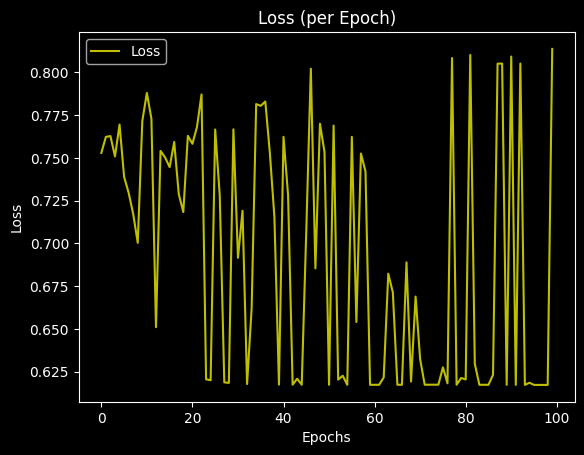

In [62]:
# Plot losses vs epochs
plt.plot([loss_history[0][i][0] for i in range(len(loss_history[0]))], 'y')
#plt.plot(val_loss_history, 'g--')
plt.legend(['Loss'])#, 'Val Loss'])
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss (per Epoch)")
plt.show()

**Almacenamiento y Pruebas de su mejor modelo**

In [63]:
# Es momento de probar el desempeño de su mejor modelo con datos de prueba
# No olvide almacenar su modelo, se sugiere estar almacenando los pesos durante
# el ciclo de entrenamiento


In [64]:
data_loader_test = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=dataset_test.__len__(), shuffle=True, num_workers=1) # Training

In [65]:
batch_x, batch_y = next(iter(data_loader_test))

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [66]:
# Get index to class
idx_to_class = {v: k for k, v in class_to_idx.items()}
idx_to_class

{0: 'PlayingCello',
 1: 'Archery',
 2: 'Diving',
 3: 'Basketball',
 4: 'VolleyballSpiking'}

In [67]:
# How to install permanently non-preinstalled libraries
!pip install torcheval && touch /root/.ipython/profile_default/startup/00-first.py && echo "import torcheval" >> /root/.ipython/profile_default/startup/00-first.py

In [68]:
from torcheval.metrics import MulticlassAccuracy

Label: 1 - Class: Archery
Model Prediction: 1 - Class: Archery


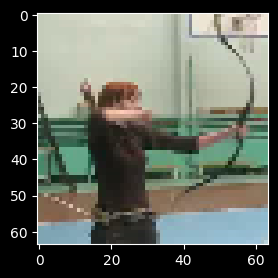

Label: 3 - Class: Basketball
Model Prediction: 3 - Class: Basketball


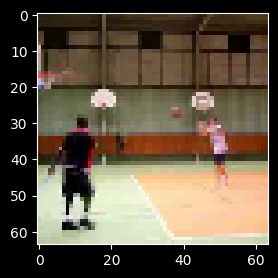

Label: 2 - Class: Diving
Model Prediction: 2 - Class: Diving


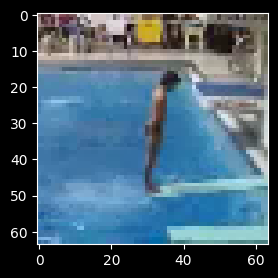

Label: 3 - Class: Basketball
Model Prediction: 3 - Class: Basketball


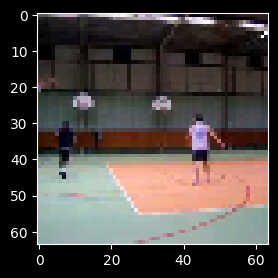

Label: 1 - Class: Archery
Model Prediction: 1 - Class: Archery


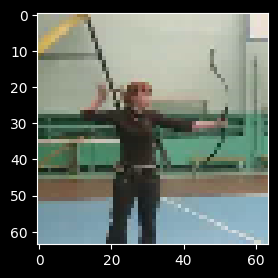

Label: 1 - Class: Archery
Model Prediction: 1 - Class: Archery


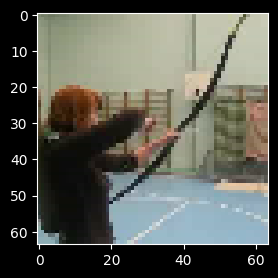

Label: 1 - Class: Archery
Model Prediction: 1 - Class: Archery


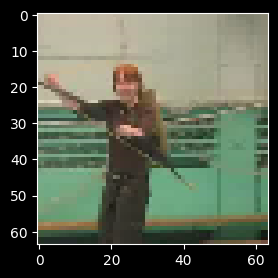

Label: 4 - Class: VolleyballSpiking
Model Prediction: 3 - Class: Basketball


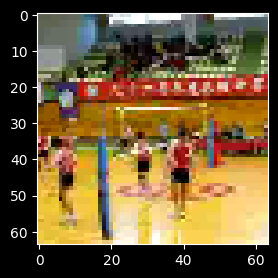

Label: 3 - Class: Basketball
Model Prediction: 3 - Class: Basketball


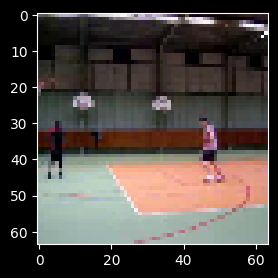

Label: 2 - Class: Diving
Model Prediction: 2 - Class: Diving


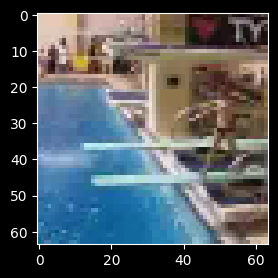

Label: 2 - Class: Diving
Model Prediction: 2 - Class: Diving


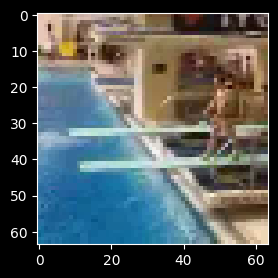

In [69]:
# Set to test mode
model_act_class.eval()
output_labels = []
target_labels = []

with torch.no_grad():
    for i in range(batch_x.shape[0]):
        # Forward pass through the network
        output_model = model_act_class(batch_x[i,:,:,:,:].to(device=device, dtype=torch.float32))

        label = torch.argmax(batch_y[i])
        label = label.to('cpu')
        label = label.numpy()
        target_labels.append(label.item())

        # Print label
        print(f"{WHITE}Label: {YELLOW}{label}{RESET} - Class: {YELLOW}{idx_to_class[label.item()]}{RESET}")

        # Get position of highest number in torch array
        max_idx = torch.argmax(output_model)
        max_idx = max_idx.to('cpu')
        max_idx = max_idx.numpy()
        output_labels.append(max_idx.item())

        # Print prediction - RED if not equal (NOT_OK), else GREEN (OK)
        if label.item() != max_idx.item():
            print(f"{WHITE}Model Prediction: {RED}{max_idx}{RESET} - Class: {RED}{idx_to_class[max_idx.item()]}{RESET}")
        else:
            print(f"{WHITE}Model Prediction: {GREEN}{max_idx}{RESET} - Class: {GREEN}{idx_to_class[max_idx.item()]}{RESET}")

        # Print first frame of each sample
        plt.figure(figsize=(3, 3))
        plt.imshow(batch_x[i,0,:,:,:].permute(1, 2, 0).to('cpu').numpy())
        plt.show()




In [70]:
type(output_labels), target_labels

(list, [1, 3, 2, 3, 1, 1, 1, 4, 3, 2, 2])

In [71]:
output_labels = torch.tensor(output_labels)
target_labels = torch.tensor(target_labels)

In [72]:
# Calculate metrics
metric = MulticlassAccuracy()
metric.update(output_labels, target_labels)
accuracy = metric.compute()
# Print GREEN if accuracy above 0.75, else RED
if accuracy > 0.75:
    print(f"{WHITE}Accuracy: {GREEN}{accuracy*100}%{RESET}")
else:
    print(f"{WHITE}Accuracy: {RED}{accuracy*100}%{RESET}")

Accuracy: 90.90909576416016%


In [73]:
# Set save path
save_path = '/content/drive/MyDrive/Colab_DL/Examen_II/model_activity_classification'

In [74]:
# Store best model
#torch.save(model_act_class.state_dict(), save_path)

In [75]:
# Create a new model instance and load previous best model
best_model = ClassificationModel(n_frames=4)
best_model.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [76]:
# Send model to cuda
best_model = best_model.to(device=device, dtype=torch.float32)
# Also for VGG16 layers
for i in range(len(best_model.net_class)):
    # To cuda
    best_model.net_class[i].to(device=device, dtype=torch.float32)
    for param in best_model.net_class[i].parameters():
        # Non-trainable parameters
        param.requires_grad = False

Label: 1 - Class: Archery
Model Prediction: 1 - Class: Archery


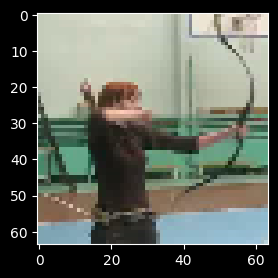

Label: 3 - Class: Basketball
Model Prediction: 3 - Class: Basketball


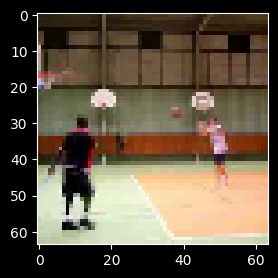

Label: 2 - Class: Diving
Model Prediction: 2 - Class: Diving


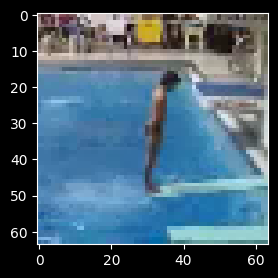

Label: 3 - Class: Basketball
Model Prediction: 3 - Class: Basketball


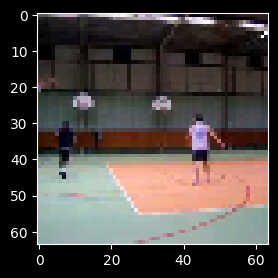

Label: 1 - Class: Archery
Model Prediction: 1 - Class: Archery


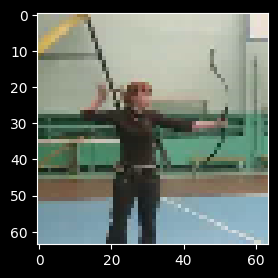

Label: 1 - Class: Archery
Model Prediction: 1 - Class: Archery


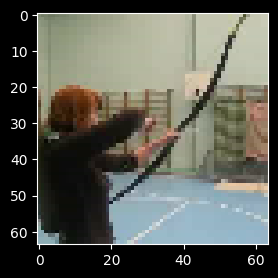

Label: 1 - Class: Archery
Model Prediction: 1 - Class: Archery


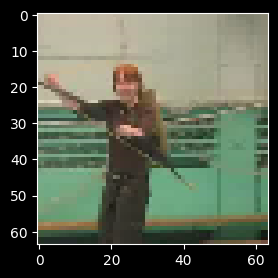

Label: 4 - Class: VolleyballSpiking
Model Prediction: 4 - Class: VolleyballSpiking


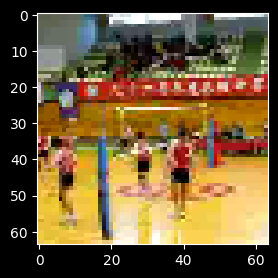

Label: 3 - Class: Basketball
Model Prediction: 3 - Class: Basketball


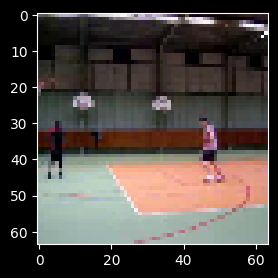

Label: 2 - Class: Diving
Model Prediction: 2 - Class: Diving


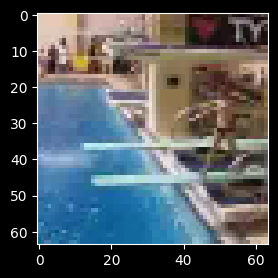

Label: 2 - Class: Diving
Model Prediction: 2 - Class: Diving


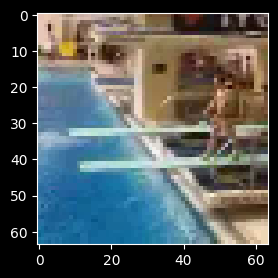

In [77]:
# Predict for same test batch
# Set to test mode
best_model.eval()
output_labels = []
target_labels = []

with torch.no_grad():
    for i in range(batch_x.shape[0]):
        # Forward pass through the network
        output_model = best_model(batch_x[i,:,:,:,:].to(device=device, dtype=torch.float32))

        label = torch.argmax(batch_y[i])
        label = label.to('cpu')
        label = label.numpy()
        target_labels.append(label.item())

        # Print label
        print(f"{WHITE}Label: {YELLOW}{label}{RESET} - Class: {YELLOW}{idx_to_class[label.item()]}{RESET}")

        # Get position of highest number in torch array
        max_idx = torch.argmax(output_model)
        max_idx = max_idx.to('cpu')
        max_idx = max_idx.numpy()
        output_labels.append(max_idx.item())

        # Print prediction - RED if not equal (NOT_OK), else GREEN (OK)
        if label.item() != max_idx.item():
            print(f"{WHITE}Model Prediction: {RED}{max_idx}{RESET} - Class: {RED}{idx_to_class[max_idx.item()]}{RESET}")
        else:
            print(f"{WHITE}Model Prediction: {GREEN}{max_idx}{RESET} - Class: {GREEN}{idx_to_class[max_idx.item()]}{RESET}")

        # Print first frame of each sample
        plt.figure(figsize=(3, 3))
        plt.imshow(batch_x[i,0,:,:,:].permute(1, 2, 0).to('cpu').numpy())
        plt.show()

In [78]:
# Best model metrics
output_labels = torch.tensor(output_labels)
target_labels = torch.tensor(target_labels)

In [79]:
# Calculate metrics
metric = MulticlassAccuracy()
metric.update(output_labels, target_labels)
accuracy = metric.compute()
# Print GREEN if accuracy above 0.75, else RED
if accuracy > 0.75:
    print(f"{YELLOW}BEST MODEL {RESET}Accuracy: {GREEN}{accuracy*100}%{RESET}")
else:
    print(f"{YELLOW}BEST MODEL {RESET}Accuracy: {RED}{accuracy*100}%{RESET}")

BEST MODEL Accuracy: 100.0%


## ¡Buena suerte!

Fecha de máxima de entrega: ***Lunes 06 de mayo, 19:00h***